# Skript for training the MC based regression network

    1. Loading necessary data
    2. Initialize model
    3. Training loop

## 1. Loading necessary data

In [20]:
import pickle
import numpy as np

annotation_dict = pickle.load(open("wsis/meningioma_grading_training_dataset/annotation_dict2.p","rb"))

In [21]:
keys_to_discard = list()
keys_for_training = list()
keys_excluded_testset=0
ldfnummer_exclude = []
testset_exclude = pickle.load(open('Testset_List.p','rb'))
for key in annotation_dict:
    if key in testset_exclude:
        ldfnummer_exclude += [annotation_dict[key]['lfd_number']]

for key in annotation_dict:
    try:
        if (annotation_dict[key]['mitotic_count'] >= 0) and (annotation_dict[key]['lfd_number'] not in ldfnummer_exclude):
            keys_for_training.append(key)
        else:
            keys_to_discard.append(key)
    except KeyError:
        keys_to_discard.append(key)

keys_excluded_testset,
ldfnummer_exclude = np.unique(ldfnummer_exclude)
ldfnummer_exclude
len(ldfnummer_exclude)

19

In [23]:
# Only the highest mitotic count of a patient is used in training
tmp = dict()
for key in annotation_dict:
    lfd_number = annotation_dict[key]['lfd_number']
    if (lfd_number in ldfnummer_exclude):
        continue
    if lfd_number not in tmp:
        tmp[lfd_number] = dict()
        tmp[lfd_number]['file'] = key
        tmp[lfd_number]['who_grade'] = annotation_dict[key]['who_grade']
        try:
            tmp[lfd_number]['mitotic_count'] = annotation_dict[key]['mitotic_count']
        except KeyError:
            tmp[lfd_number]['mitotic_count'] = 0
    try:
        if tmp[lfd_number]['mitotic_count'] < annotation_dict[key]['mitotic_count']:
            tmp[lfd_number]['file'] = key
            tmp[lfd_number]['who_grade'] = annotation_dict[key]['who_grade']
            tmp[lfd_number]['mitotic_count'] = annotation_dict[key]['mitotic_count']
    except KeyError:
        continue

patients = tmp

In [24]:
# Standardize the mitotic count
mcs = [patients[key]['mitotic_count'] for key in patients]
mean_mcs = np.mean(mcs)
std_mcs = np.std(mcs)
mcs = [(m-mean_mcs)/std_mcs for m in mcs]
# Normalize
max_mcs = max(mcs)
mcs = [m/max_mcs for m in mcs]
for key,m in zip (patients, mcs):
    patients[key]['mitotic_count'] = m

(array([309.,  18.,   8.,   2.,   1.,   2.,   0.,   0.,   0.,   1.]),
 array([-0.05500172,  0.05049845,  0.15599862,  0.2614988 ,  0.36699897,
         0.47249914,  0.57799931,  0.68349948,  0.78899966,  0.89449983,
         1.        ]),
 <BarContainer object of 10 artists>)

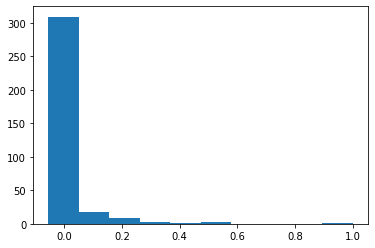

In [25]:
import matplotlib.pyplot as plt

plt.hist(mcs)

In [26]:
import random

random.seed(6)
# 15 % validation data
val_numbers = [lfd_number for lfd_number in random.sample(patients.keys(),54)]
train_numbers = [lfd_number for lfd_number in patients if lfd_number not in val_numbers]
mcs_train = [patients[lfd_number]['mitotic_count'] for lfd_number in train_numbers]
grades_train = [patients[lfd_number]['who_grade'] for lfd_number in train_numbers]

mcs_val = [patients[lfd_number]['mitotic_count'] for lfd_number in val_numbers]
grades_val = [patients[lfd_number]['who_grade'] for lfd_number in val_numbers]

In [27]:
import torch

mcs_train = torch.tensor(mcs_train, dtype = torch.float32).reshape(-1,1)
grades_train = torch.tensor(grades_train, dtype = torch.float32).reshape(-1,1)

mcs_val = torch.tensor(mcs_val, dtype = torch.float32).reshape(-1,1)
grades_val = torch.tensor(grades_val, dtype = torch.float32).reshape(-1,1)


## 2. Initialize model

In [28]:
import Model2

model = Model2.SimpleRegressionModel()

## 3. Training loop

In [29]:
def train_loop(train_data,train_labels, model, loss_fn, optimizer, batch_size = 1):
    size = len(train_data)
    running = list()
    for  batch, (X, y) in enumerate(zip(train_data,train_labels)):
        # Compute prediction and loss
        pred = model(X)
        # loss pro item
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running.append(loss.item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # current loss
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print(f"Mean Training Loss: {sum(running)/len(running)}")
    return sum(running)/len(running)
  
            
def test_loop(test_data,test_labels, model, loss_fn):
    size = len(test_data)
    test_loss = 0

    with torch.no_grad():
        for X, y in zip(test_data,test_labels):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= size
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss


In [30]:
model = SimpleRegressionModel()

loss_fn = torch.nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=5,verbose=True)

In [31]:
from numpy import random
# function for sampling the data like for the other regression models
def sample_train_data(mcs_train,grades_train,train_data_length):
    train_vektor = list()
    train_labels = list()
    for i in range(train_data_length):
        grade = random.randint(1,4,1)
        train_vektor.append(mcs_train[np.random.choice(np.where(grades_train == float(grade))[0],1)])
        train_labels.append(grades_train[np.random.choice(np.where(grades_train == float(grade))[0],1)])
    return train_vektor,train_labels

In [ ]:
# model training
epochs = 50
losses = list()
train_loss = list()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    sampled_mcs,sampled_labels = sample_train_data(mcs_train,grades_train,300)
    train_loss.append(train_loop(sampled_mcs,sampled_labels, model, loss_fn, optimizer))
    sampled_mcs,sampled_labels = sample_train_data(mcs_val,grades_val,100)
    val_loss = test_loop(sampled_mcs,sampled_labels, model, loss_fn)
    scheduler.step(val_loss)
    losses.append(val_loss)
    
    # model selection
    if t == 0:
        best_loss = val_loss
    elif best_loss > val_loss:
        print(f"Best model saved in Epoch {t+1}")
        best_loss = val_loss
        best_model = model.state_dict()
        
print("Done!")

Epoch 1
-------------------------------
loss: 2.528661  [    0/  300]
loss: 1.851999  [  100/  300]
loss: 1.193662  [  200/  300]
Mean Training Loss: 0.7679080195900921
Avg loss: 0.474115 

Epoch 2
-------------------------------
loss: 0.032006  [    0/  300]
loss: 0.505287  [  100/  300]
loss: 0.504113  [  200/  300]
Mean Training Loss: 0.36574619974814293
Avg loss: 0.271852 

Best model saved in Epoch 2
Epoch 3
-------------------------------
loss: 0.195310  [    0/  300]
loss: 0.339838  [  100/  300]
loss: 0.488459  [  200/  300]
Mean Training Loss: 0.278512299869714
Avg loss: 0.280430 

Epoch 4
-------------------------------
loss: 0.109515  [    0/  300]
loss: 0.159989  [  100/  300]
loss: 0.026877  [  200/  300]
Mean Training Loss: 0.25181460207715645
Avg loss: 0.200913 

Best model saved in Epoch 4
Epoch 5
-------------------------------
loss: 0.390163  [    0/  300]
loss: 0.072854  [  100/  300]
loss: 0.418624  [  200/  300]
Mean Training Loss: 0.25838843808926565
Avg loss: 0.1

In [ ]:
test_data = torch.tensor(np.arange(min(mcs_train),max(mcs_train),0.01),dtype = torch.float32).reshape(-1,1)
with torch.no_grad():
    out = model(test_data)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_data,out.numpy())
plt.xlabel('Mitotic Count')
plt.ylabel('Kontinuierlicher WHO-Grad')
plt.title('Function learnd by Regression Network')
plt.scatter(sampled_mcs,sampled_labels)

In [ ]:
plt.plot(losses,label = 'val loss')
plt.plot(train_loss, label = 'train loss')
plt.legend()
